In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import utils_plots as ut
seed = 42
random.seed(seed)
np.random.seed(seed)

/opt/miniconda3/envs/tf_tcg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
basin = 'NEP'
perc = 75
predictors_type = 'original+detrend' # 'original', 'deseason', 'detrend', 'original+detrend' (original predictions, detrended for timeseries comparison)
# Set parameters for run name
if predictors_type == 'original' or predictors_type == 'original+detrend':
    n_clusters_dict = {'NEP': 7, 'NWP': 10, 'NA': 6, 'NI': 7, 'SI': 6, 'SP': 9}
    str_pt = 'nc'
elif predictors_type == 'deseason':
    n_clusters_dict = {'NEP': 6, 'NWP': 10, 'NA': 10, 'NI': 8, 'SI': 8, 'SP': 9}
    str_pt = 'DSnc'
elif predictors_type == 'detrend':
    n_clusters_dict = {'NEP': 12, 'NWP': 10, 'NA': 12, 'NI': 11, 'SI': 7, 'SP': 10}
    str_pt = 'DTnc'
n_clusters = n_clusters_dict[basin]
run_name = f'selfeat{perc}_top20_{str_pt}{n_clusters}_nv8_nd9'
# Set years range and number of folds
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
# Set directories and file paths, then load file containing predictors and target
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
results_dir = os.path.join(fs_dir, 'results')

In [3]:
# Hyperparameters for Random Forest
n_est = 135
crit = 'squared_error'
max_d = None
min_samples_s = 2
min_samples_f = 1
max_f = 1.0

In [4]:
# Retrieve the clusters type of data
if predictors_type == 'deseason':
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    target_file = 'target_deseasonal_1980-2022_2.5x2.5.csv'
elif predictors_type == 'detrend':
    cluster_data = f'{basin}_{n_clusters}clusters_detrend'
    target_file = 'target_detrend_1980-2022_2.5x2.5.csv'
else:
    cluster_data = f'{basin}_{n_clusters}clusters'
    target_file = 'target_1980-2022_2.5x2.5.csv'
fs_dir = os.path.join(project_dir, 'FS_TCG')
cluster_data_dir = os.path.join(fs_dir, 'data', cluster_data)
# predictors
predictor_file = f'predictors_1980-2022_{n_clusters}clusters_8vars_9idxs.csv'
predictors_df = pd.read_csv(os.path.join(cluster_data_dir, predictor_file), index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
predictors_df = predictors_df.loc[predictors_df.index.year.isin(years)]
# target
target_df = pd.read_csv(os.path.join(cluster_data_dir, target_file), index_col=0)
target_df.index = pd.to_datetime(target_df.index)
target_df = target_df.loc[target_df.index.year.isin(years)]
# gpis
gpis_file = f'{basin}_2.5x2.5_gpis_time_series.csv'
gpis_path = os.path.join(fs_dir, 'data', gpis_file)
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpis_df = gpis_df.loc[gpis_df.index.year.isin(years)]
# Build dataset of selected features and dataset with all features
sel_feat_perc_path = os.path.join(results_dir, f'selected_features_best_models_{basin}_{str_pt}{n_clusters}.csv')
df_sel_feat_perc = pd.read_csv(sel_feat_perc_path, index_col=0)
sel_perc = str(perc)
selected_features = df_sel_feat_perc[sel_perc].dropna().to_list()
dataset_opt = predictors_df[selected_features]
dataset_opt.columns = [f'{feat}_lag0' for feat in dataset_opt.columns]
dataset_opt = dataset_opt.assign(tcg=target_df['tcg'])
dataset_opt_noFS = target_df.copy()
for l in range(1):
    for var in predictors_df.columns:
        col_df = pd.DataFrame(predictors_df[var].shift(l).values, index=dataset_opt_noFS.index, columns=[f'{var}_lag{l}'])
        dataset_opt_noFS = pd.concat([dataset_opt_noFS, col_df], axis=1)

In [5]:
# Get the run info, data and predictions from NN model
Y_pred_nn, Y_pred_nn_noFS, _, _, mlps, mlps_noFS, shap_values_mlp = ut.runs_info(basin, run_name, project_dir)
Y_pred_nn_df = pd.concat(Y_pred_nn)
Y_pred_nn_noFS_df = pd.concat(Y_pred_nn_noFS)
# If predictors are original or original+detrended, set them to 0
if predictors_type == 'original' or predictors_type == 'original+detrend':
    Y_pred_nn_df[Y_pred_nn_df < 0] = 0.0
    Y_pred_nn_noFS_df[Y_pred_nn_noFS_df < 0] = 0.0
# Remove trend from predictions if considering the 'original+detrend' predictors
if predictors_type == 'original+detrend':
    decomp_pred_nn = STL(Y_pred_nn_df['tcg']).fit()
    decomp_pred_nn_noFS = STL(Y_pred_nn_noFS_df['tcg']).fit()
    Y_pred_nn_df['tcg'] = Y_pred_nn_df['tcg'] - decomp_pred_nn.trend
    Y_pred_nn_noFS_df['tcg'] = Y_pred_nn_noFS_df['tcg'] - decomp_pred_nn_noFS.trend

In [6]:
# Train a random forest model with 3 folds cross-validation
kfold = KFold(n_splits=n_folds)
Y_column = 'tcg' # Target variable
Y_pred_df = pd.DataFrame()
Y_pred_noFS_df = pd.DataFrame()

for n_fold, (train_index, test_index) in enumerate(kfold.split(years)):
    # Set the indices for the training and test datasets
    train_years = years[train_index]
    test_years = years[test_index]
    # Split the optimized dataset
    train_indices = dataset_opt.index.year.isin(train_years)
    test_indices = dataset_opt.index.year.isin(test_years)
    train_dataset = dataset_opt[train_indices]
    test_dataset = dataset_opt[test_indices]
    # Split the entire dataset 
    train_indices_noFS = dataset_opt_noFS.index.year.isin(train_years)
    test_indices_noFS = dataset_opt_noFS.index.year.isin(test_years)
    train_dataset_noFS = dataset_opt_noFS[train_indices_noFS]
    test_dataset_noFS = dataset_opt_noFS[test_indices_noFS]
    # Standardize the optimized dataset
    X_train = train_dataset[train_dataset.columns.drop([Y_column])]
    Y_train = train_dataset[Y_column]
    X_test_fold = test_dataset[test_dataset.columns.drop([Y_column])]
    Y_test_fold = test_dataset[Y_column]
    scaler = preprocessing.MinMaxScaler()
    X_std_train = scaler.fit(X_train)
    X_std_train = scaler.transform(X_train)
    X_std_test = scaler.transform(X_test_fold)
    X_train = pd.DataFrame(X_std_train, columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(X_std_test, columns=X_test_fold.columns, index=X_test_fold.index)
    # Standardize the entire dataset
    X_train_noFS = train_dataset_noFS[train_dataset_noFS.columns.drop([Y_column])]
    X_test_fold_noFS = test_dataset_noFS[test_dataset_noFS.columns.drop([Y_column])]
    scaler_noFS = preprocessing.MinMaxScaler()
    X_std_train_noFS = scaler_noFS.fit(X_train_noFS)
    X_std_train_noFS = scaler_noFS.transform(X_train_noFS)
    X_std_test_noFS = scaler_noFS.transform(X_test_fold_noFS)
    X_train_noFS = pd.DataFrame(X_std_train_noFS, columns=X_train_noFS.columns, index=X_train_noFS.index)
    X_test_noFS = pd.DataFrame(X_std_test_noFS, columns=X_test_fold_noFS.columns, index=X_test_fold_noFS.index)
    ## Train the FS model ##
    rf = RandomForestRegressor(n_estimators=n_est, criterion=crit, max_depth=max_d, min_samples_split=min_samples_s, min_samples_leaf=min_samples_f, max_features=max_f, random_state=seed)
    rf.fit(X_train, Y_train)
    # Predict the test dataset
    Y_pred_fold = rf.predict(X_test)
    Y_pred_fold = pd.DataFrame(Y_pred_fold, index=Y_test_fold.index, columns=[f'tcg'])
    Y_pred_df = pd.concat([Y_pred_df, Y_pred_fold])
    ## Train the non-FS model ##
    rf_noFS = RandomForestRegressor(n_estimators=n_est, criterion=crit, max_depth=max_d, min_samples_split=min_samples_s, min_samples_leaf=min_samples_f, max_features=max_f, random_state=seed)
    rf_noFS.fit(X_train_noFS, Y_train)
    # Predict the test dataset
    Y_pred_fold_noFS = rf_noFS.predict(X_test_noFS)
    Y_pred_fold_noFS = pd.DataFrame(Y_pred_fold_noFS, index=Y_test_fold.index, columns=[f'tcg'])
    Y_pred_noFS_df = pd.concat([Y_pred_noFS_df, Y_pred_fold_noFS])
# If predictions with original data are negative, set them to 0
if predictors_type == 'original' or predictors_type == 'original+detrend':
    Y_pred_df[Y_pred_df < 0] = 0.0
    Y_pred_noFS_df[Y_pred_noFS_df < 0] = 0.0
# Remove trend from predictions if considering the 'original+detrend' option
if predictors_type == 'original+detrend':
    decomp_pred_FS = STL(Y_pred_df['tcg']).fit()
    decomp_pred_noFS = STL(Y_pred_noFS_df['tcg']).fit()
    Y_pred_df['tcg'] = Y_pred_df['tcg'] - decomp_pred_FS.trend
    Y_pred_noFS_df['tcg'] = Y_pred_noFS_df['tcg'] - decomp_pred_noFS.trend
    decomp_target = STL(target_df['tcg']).fit()
    target_df['tcg'] = target_df['tcg'] - decomp_target.trend

**Time series Trajectories**

In [7]:
# Annual data without trend and seasonality
target_df_annual = target_df.groupby(target_df.index.year).sum()
Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
Y_pred_nn_df_annual = Y_pred_nn_df.groupby(Y_pred_nn_df.index.year).sum()
Y_pred_nn_noFS_df_annual = Y_pred_nn_noFS_df.groupby(Y_pred_nn_noFS_df.index.year).sum()
# GPIs time series with trend and seasonality
engpi_TS = gpis_df['engpi']
ogpi_TS = gpis_df['ogpi']
# GPIs time series without trend and seasonality
decomp_engpi = STL(engpi_TS).fit()
decomp_ogpi = STL(ogpi_TS).fit()
if predictors_type == 'deseason':
    engpi = engpi_TS - decomp_engpi.seasonal
    ogpi = ogpi_TS - decomp_ogpi.seasonal
elif predictors_type == 'detrend' or predictors_type == 'original+detrend':
    engpi = engpi_TS - decomp_engpi.trend
    ogpi = ogpi_TS - decomp_ogpi.trend
else:
    engpi = engpi_TS
    ogpi = ogpi_TS
# Annual data of the GPIs
engpi_annual = engpi.groupby(engpi.index.year).sum()
ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly
r, p_value = pearsonr(target_df['tcg'], Y_pred_df['tcg'])
r_noFS, p_value_noFS = pearsonr(target_df['tcg'], Y_pred_noFS_df['tcg'])
r_nn, p_value_nn = pearsonr(target_df['tcg'], Y_pred_nn_df['tcg'])
r_nn_noFS, p_value_nn_noFS = pearsonr(target_df['tcg'], Y_pred_nn_noFS_df['tcg'])
r_engpi, p_value_engpi = pearsonr(target_df['tcg'], engpi)
r_ogpi, p_value_ogpi = pearsonr(target_df['tcg'], ogpi)
mse = mean_squared_error(target_df['tcg'], Y_pred_df['tcg'])
mse_nn = mean_squared_error(target_df['tcg'], Y_pred_nn_df['tcg'])
mse_nn_noFS = mean_squared_error(target_df['tcg'], Y_pred_nn_noFS_df['tcg'])
mse_noFS = mean_squared_error(target_df['tcg'], Y_pred_noFS_df['tcg'])
mse_engpi = mean_squared_error(target_df['tcg'], engpi)
mse_ogpi = mean_squared_error(target_df['tcg'], ogpi)
# Annual
rY, p_valueY = pearsonr(target_df_annual['tcg'], Y_pred_df_annual['tcg'])
rY_noFS, p_value_noFSY = pearsonr(target_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'])
rY_nn, p_value_nnY = pearsonr(target_df_annual['tcg'], Y_pred_nn_df_annual['tcg'])
rY_nn_noFS, p_value_nn_noFSY = pearsonr(target_df_annual['tcg'], Y_pred_nn_noFS_df_annual['tcg'])
rY_engpi, p_value_engpiY = pearsonr(target_df_annual['tcg'], engpi_annual)
rY_ogpi, p_value_ogpiY = pearsonr(target_df_annual['tcg'], ogpi_annual)
mseY = mean_squared_error(target_df_annual['tcg'], Y_pred_df_annual['tcg'])
mseY_noFS = mean_squared_error(target_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'])
mseY_nn = mean_squared_error(target_df_annual['tcg'], Y_pred_nn_df_annual['tcg'])
mseY_nn_noFS = mean_squared_error(target_df_annual['tcg'], Y_pred_nn_noFS_df_annual['tcg'])
mseY_engpi = mean_squared_error(target_df_annual['tcg'], engpi_annual)
mseY_ogpi = mean_squared_error(target_df_annual['tcg'], ogpi_annual)

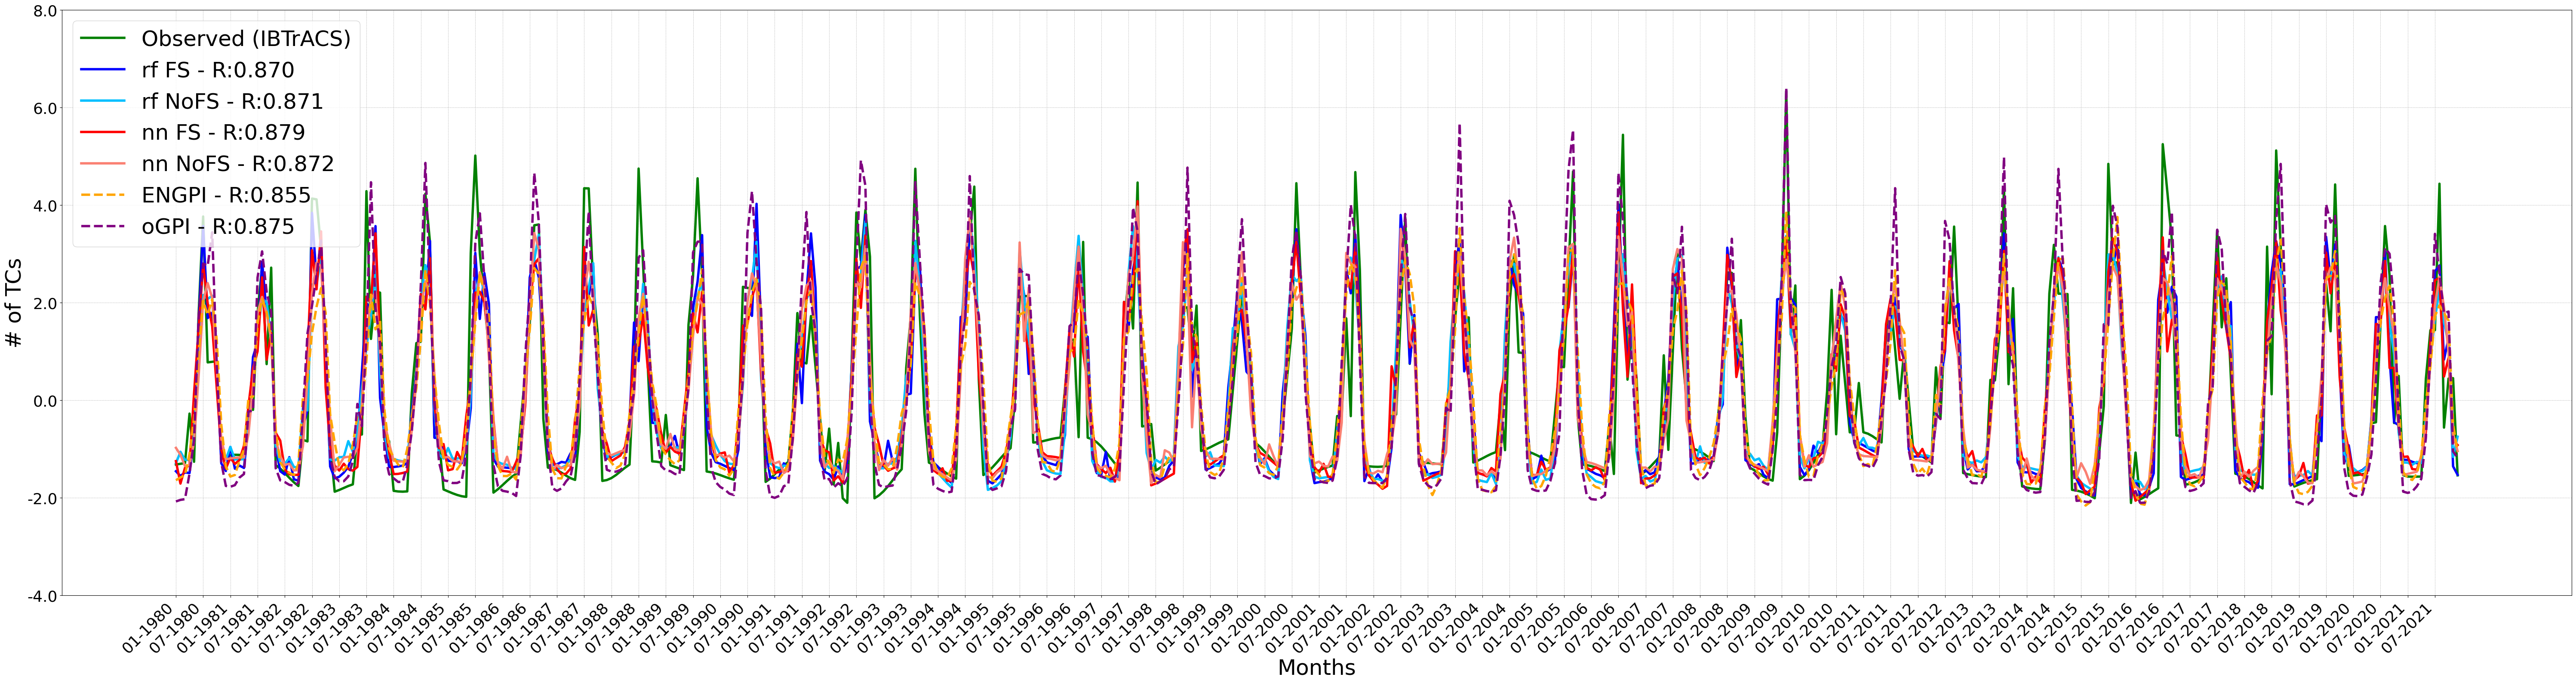

In [8]:
# Plotting the monthly time series 
fig_ts = plt.figure(figsize=(60, 16))
ax = fig_ts.add_subplot(111)
xticks = pd.Series(target_df['tcg'].index).dt.strftime('%m-%Y').to_numpy()
# observations
ax.plot(xticks, target_df['tcg'], label='Observed (IBTrACS)', color='green', linewidth=4)
# predictions of random forest
ax.plot(xticks, Y_pred_df['tcg'], label=f'rf FS - R:{r:.3f}', color='blue', linewidth=4)
ax.plot(xticks, Y_pred_noFS_df['tcg'], label=f'rf NoFS - R:{r_noFS:.3f}', color='deepskyblue', linewidth=4)
# predictions of neural network
ax.plot(xticks, Y_pred_nn_df['tcg'], label=f'nn FS - R:{r_nn:.3f}', color='red', linewidth=4)
ax.plot(xticks, Y_pred_nn_noFS_df['tcg'], label=f'nn NoFS - R:{r_nn_noFS:.3f}', color='salmon', linewidth=4)
# gpis
ax.plot(xticks, engpi, label=f'ENGPI - R:{r_engpi:.3f}', color='orange', linewidth=4, linestyle='--')
ax.plot(xticks, ogpi, label=f'oGPI - R:{r_ogpi:.3f}', color='purple', linewidth=4, linestyle='--')
# set figure parameters
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xticks(ticks=np.arange(len(xticks))[::6])
ax.set_xticklabels(xticks[::6], rotation=45, fontsize=26, ha='right')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=26)
ax.set_xlabel('Months', fontsize=36)
ax.set_ylabel('# of TCs', fontsize=36)
ax.legend(fontsize=36, loc='best')
# Finalize the figure
fig_ts.set_tight_layout(True)
plt.show()

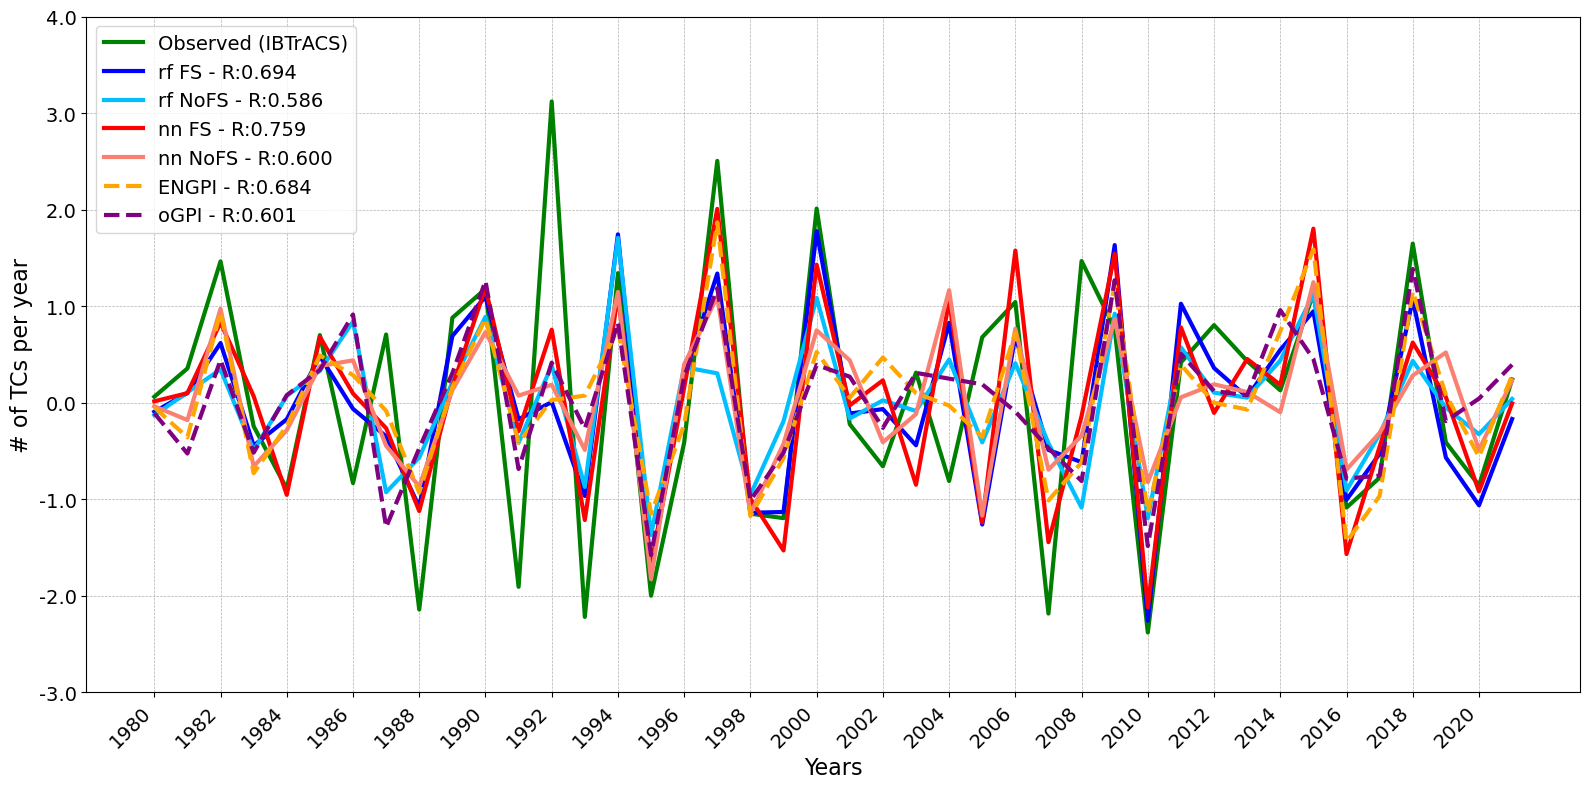

In [9]:
# Plotting the annual time series
fig_annual = plt.figure(figsize=(16, 8))
axY = fig_annual.add_subplot(111)
# observations
axY.plot(target_df_annual['tcg'].index, target_df_annual['tcg'], label='Observed (IBTrACS)', color='green', linewidth=3)
# random forest predictions
axY.plot(Y_pred_df_annual['tcg'].index, Y_pred_df_annual['tcg'], label=f'rf FS - R:{rY:.3f}', color='blue', linewidth=3)
axY.plot(Y_pred_noFS_df_annual['tcg'].index, Y_pred_noFS_df_annual['tcg'], label=f'rf NoFS - R:{rY_noFS:.3f}', color='deepskyblue', linewidth=3)
# neural network predictions
axY.plot(Y_pred_nn_df_annual['tcg'].index, Y_pred_nn_df_annual['tcg'], label=f'nn FS - R:{rY_nn:.3f}', color='red', linewidth=3)
axY.plot(Y_pred_nn_noFS_df_annual['tcg'].index, Y_pred_nn_noFS_df_annual['tcg'], label=f'nn NoFS - R:{rY_nn_noFS:.3f}', color='salmon', linewidth=3)
# gpis
axY.plot(engpi_annual.index, engpi_annual, label=f'ENGPI - R:{rY_engpi:.3f}', color='orange', linewidth=3, linestyle='--')
axY.plot(ogpi_annual.index, ogpi_annual, label=f'oGPI - R:{rY_ogpi:.3f}', color='purple', linewidth=3, linestyle='--')
# set figure parameters
axY.grid(True, which='both', linestyle='--', linewidth=0.5)
axY.set_xticks(target_df_annual['tcg'].index[::2])
axY.set_xticklabels(target_df_annual['tcg'].index[::2], rotation=45, fontsize=14, ha='right')
axY.set_yticks(axY.get_yticks())
axY.set_yticklabels(axY.get_yticks(), fontsize=14)
axY.set_xlabel('Years', fontsize=16)
axY.set_ylabel('# of TCs per year', fontsize=16)
axY.legend(fontsize=14, loc='best')
# Finalize the figure
fig_annual.set_tight_layout(True)

In [10]:
print(f'=== annual mse ===')
print(f'rf fs: {mseY:.3f}')
print(f'rf noFS: {mseY_noFS:.3f}')
print(f'nn fs: {mseY_nn:.3f}')
print(f'nn noFS: {mseY_nn_noFS:.3f}')
print(f'engpi: {mseY_engpi:.3f}')
print(f'ogpi: {mseY_ogpi:.3f}')
print(f'=== p values ===')
print(f'rf fs: {p_valueY:.3f}')
print(f'rf noFS: {p_value_noFSY:.3f}')
print(f'nn fs: {p_value_nnY:.3f}')
print(f'nn noFS: {p_value_nn_noFSY:.3f}')
print(f'engpi: {p_value_engpiY:.3f}')
print(f'ogpi: {p_value_ogpiY:.3f}')

=== annual mse ===
rf fs: 0.898
rf noFS: 1.146
nn fs: 0.733
nn noFS: 1.115
engpi: 0.939
ogpi: 1.108
=== p values ===
rf fs: 0.000
rf noFS: 0.000
nn fs: 0.000
nn noFS: 0.000
engpi: 0.000
ogpi: 0.000


In [11]:
# Train a random forest model adding also the GPIs time series as inputs
dataset_opt_with_gpis = pd.concat([gpis_df, dataset_opt], axis=1)
dataset_opt_noFS_with_gpis = pd.concat([gpis_df, dataset_opt_noFS], axis=1)

kfold = KFold(n_splits=n_folds)
Y_column = 'tcg' # Target variable
Y_pred_df_with_gpis = pd.DataFrame()
Y_pred_noFS_df_with_gpis = pd.DataFrame()

for n_fold, (train_index, test_index) in enumerate(kfold.split(years)):
    # Set the indices for the training and test datasets
    train_years = years[train_index]
    test_years = years[test_index]
    # Split the optimized dataset
    train_indices = dataset_opt_with_gpis.index.year.isin(train_years)
    test_indices = dataset_opt_with_gpis.index.year.isin(test_years)
    train_dataset = dataset_opt_with_gpis[train_indices]
    test_dataset = dataset_opt_with_gpis[test_indices]
    # Split the entire dataset 
    train_indices_noFS = dataset_opt_noFS_with_gpis.index.year.isin(train_years)
    test_indices_noFS = dataset_opt_noFS_with_gpis.index.year.isin(test_years)
    train_dataset_noFS = dataset_opt_noFS_with_gpis[train_indices_noFS]
    test_dataset_noFS = dataset_opt_noFS_with_gpis[test_indices_noFS]
    # Standardize the optimized dataset
    X_train = train_dataset[train_dataset.columns.drop([Y_column])]
    Y_train = train_dataset[Y_column]
    X_test_fold = test_dataset[test_dataset.columns.drop([Y_column])]
    Y_test_fold = test_dataset[Y_column]
    scaler = preprocessing.MinMaxScaler()
    X_std_train = scaler.fit(X_train)
    X_std_train = scaler.transform(X_train)
    X_std_test = scaler.transform(X_test_fold)
    X_train = pd.DataFrame(X_std_train, columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(X_std_test, columns=X_test_fold.columns, index=X_test_fold.index)
    # Standardize the entire dataset
    X_train_noFS = train_dataset_noFS[train_dataset_noFS.columns.drop([Y_column])]
    X_test_fold_noFS = test_dataset_noFS[test_dataset_noFS.columns.drop([Y_column])]
    scaler_noFS = preprocessing.MinMaxScaler()
    X_std_train_noFS = scaler_noFS.fit(X_train_noFS)
    X_std_train_noFS = scaler_noFS.transform(X_train_noFS)
    X_std_test_noFS = scaler_noFS.transform(X_test_fold_noFS)
    X_train_noFS = pd.DataFrame(X_std_train_noFS, columns=X_train_noFS.columns, index=X_train_noFS.index)
    X_test_noFS = pd.DataFrame(X_std_test_noFS, columns=X_test_fold_noFS.columns, index=X_test_fold_noFS.index)
    ## Train the FS model ##
    rf = RandomForestRegressor(n_estimators=n_est, criterion=crit, random_state=seed)
    rf.fit(X_train, Y_train)
    # Predict the test dataset
    Y_pred_fold = rf.predict(X_test)
    Y_pred_fold = pd.DataFrame(Y_pred_fold, index=Y_test_fold.index, columns=[f'tcg'])
    Y_pred_df_with_gpis = pd.concat([Y_pred_df_with_gpis, Y_pred_fold])
    ## Train the non-FS model ##
    rf_noFS = RandomForestRegressor(n_estimators=n_est, criterion=crit, random_state=seed)
    rf_noFS.fit(X_train_noFS, Y_train)
    # Predict the test dataset
    Y_pred_fold_noFS = rf_noFS.predict(X_test_noFS)
    Y_pred_fold_noFS = pd.DataFrame(Y_pred_fold_noFS, index=Y_test_fold.index, columns=[f'tcg'])
    Y_pred_noFS_df_with_gpis = pd.concat([Y_pred_noFS_df_with_gpis, Y_pred_fold_noFS])
# If predictions with original data are negative, set them to 0
if predictors_type == 'original' or predictors_type == 'original+detrend':
    Y_pred_df_with_gpis[Y_pred_df_with_gpis < 0] = 0.0
    Y_pred_noFS_df_with_gpis[Y_pred_noFS_df_with_gpis < 0] = 0.0
# Remove trend from predictions if considering the 'original+detrend' option
if predictors_type == 'original+detrend':
    decomp_pred_FS = STL(Y_pred_df_with_gpis['tcg']).fit()
    decomp_pred_noFS = STL(Y_pred_noFS_df_with_gpis['tcg']).fit()
    Y_pred_df_with_gpis['tcg'] = Y_pred_df_with_gpis['tcg'] - decomp_pred_FS.trend
    Y_pred_noFS_df_with_gpis['tcg'] = Y_pred_noFS_df_with_gpis['tcg'] - decomp_pred_noFS.trend
    decomp_target = STL(target_df['tcg']).fit()
    target_df['tcg'] = target_df['tcg'] - decomp_target.trend

**Time series Trajectories**

In [12]:
# Annual data without trend and seasonality
target_df_annual = target_df.groupby(target_df.index.year).sum()
Y_pred_df_annual_with_gpis = Y_pred_df_with_gpis.groupby(Y_pred_df_with_gpis.index.year).sum()
Y_pred_noFS_df_annual_with_gpis = Y_pred_noFS_df_with_gpis.groupby(Y_pred_noFS_df_with_gpis.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly
r_with_gpis, p_value_with_gpis = pearsonr(target_df['tcg'], Y_pred_df_with_gpis['tcg'])
r_noFS_with_gpis, p_value_noFS_with_gpis = pearsonr(target_df['tcg'], Y_pred_noFS_df_with_gpis['tcg'])
mse_with_gpis = mean_squared_error(target_df['tcg'], Y_pred_df_with_gpis['tcg'])
mse_noFS_with_gpis = mean_squared_error(target_df['tcg'], Y_pred_noFS_df_with_gpis['tcg'])
# Annual
rY_with_gpis, p_valueY_with_gpis = pearsonr(target_df_annual['tcg'], Y_pred_df_annual_with_gpis['tcg'])
rY_noFS_with_gpis, p_value_noFSY_with_gpis = pearsonr(target_df_annual['tcg'], Y_pred_noFS_df_annual_with_gpis['tcg'])
mseY_with_gpis = mean_squared_error(target_df_annual['tcg'], Y_pred_df_annual_with_gpis['tcg'])
mseY_noFS_with_gpis = mean_squared_error(target_df_annual['tcg'], Y_pred_noFS_df_annual_with_gpis['tcg'])

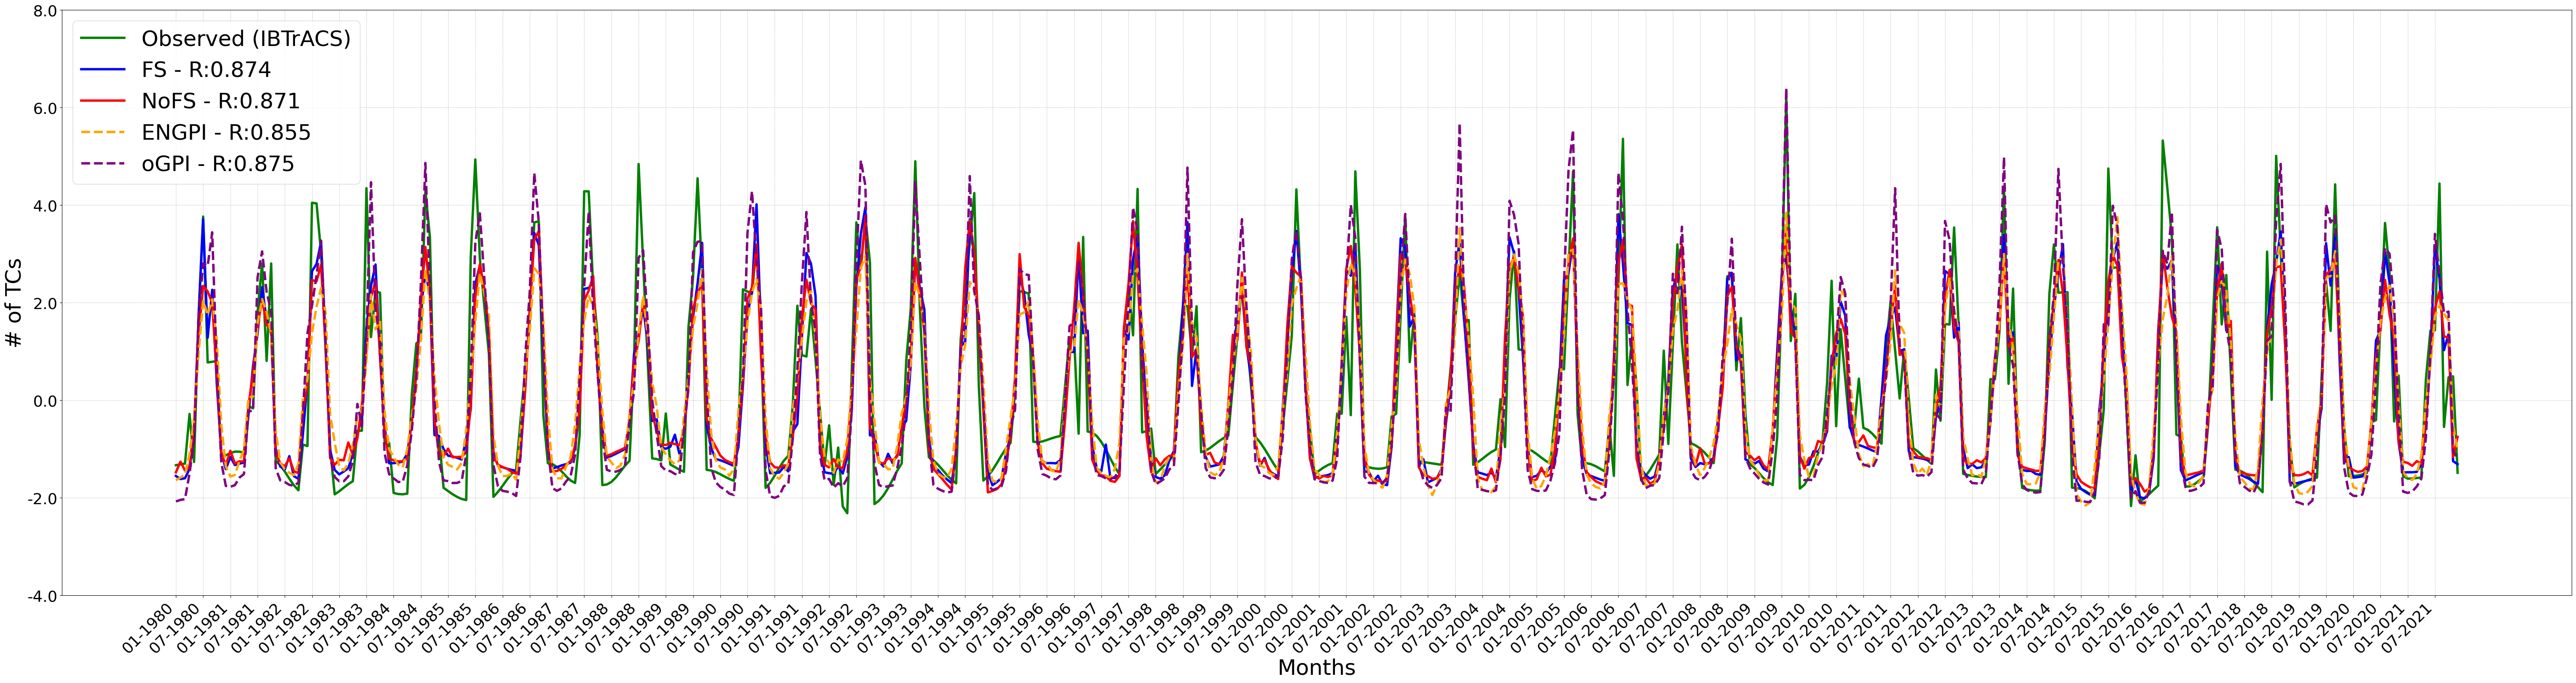

In [13]:
# Plotting the monthly time series 
fig_ts = ut.plot_monthly_time_series(target_df['tcg'], Y_pred_df_with_gpis['tcg'], Y_pred_noFS_df_with_gpis['tcg'], engpi, ogpi, r_with_gpis, r_noFS_with_gpis, r_engpi, r_ogpi)

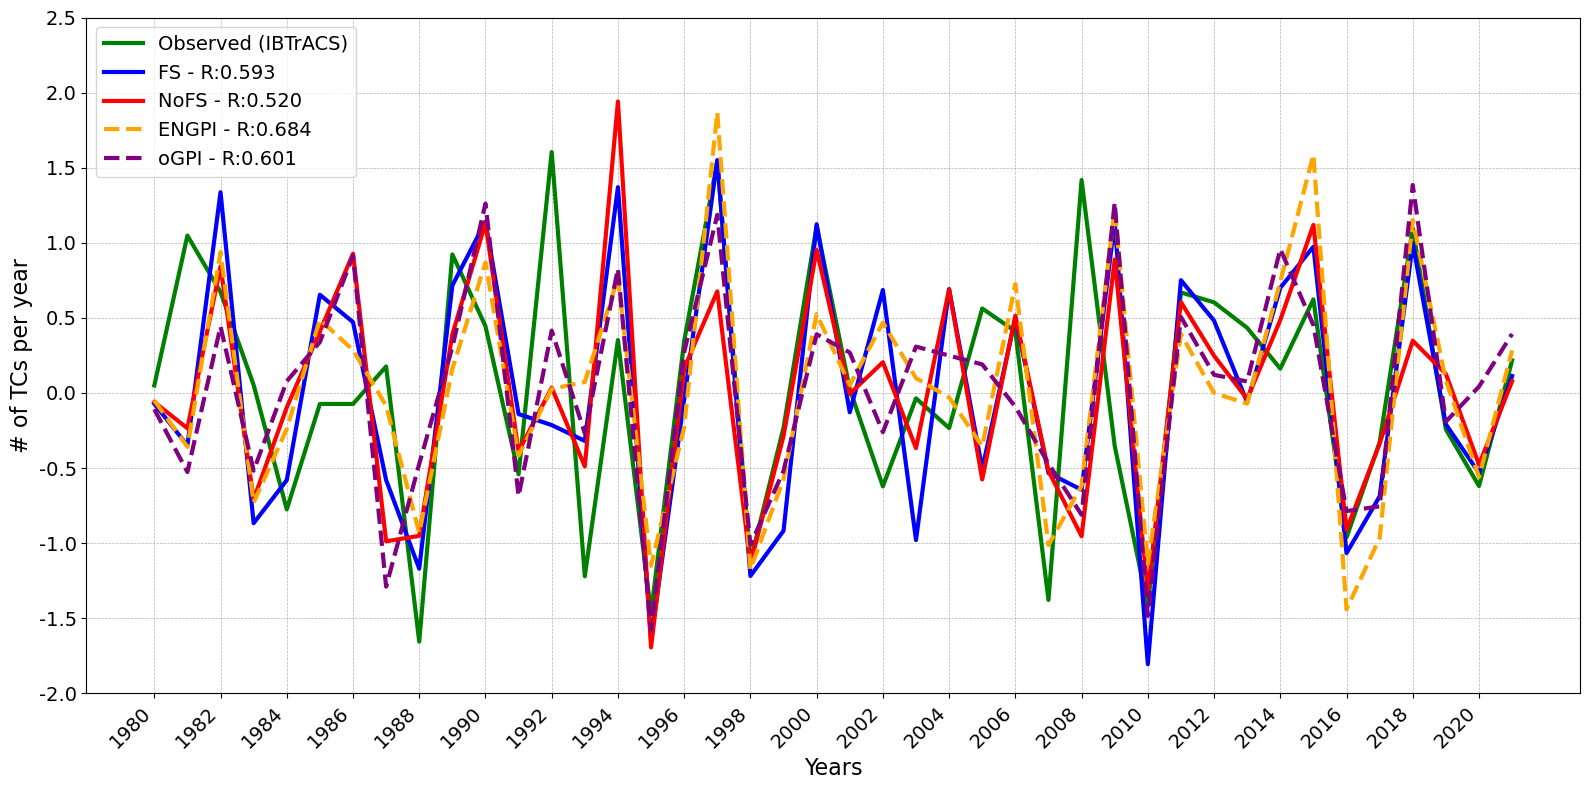

In [14]:
# Plotting the annual time series
fig_annual = ut.plot_annual_time_series(target_df_annual['tcg'], Y_pred_df_annual_with_gpis['tcg'], Y_pred_noFS_df_annual_with_gpis['tcg'], engpi_annual, ogpi_annual, rY_with_gpis, rY_noFS_with_gpis, rY_engpi, rY_ogpi)

In [15]:
print(f'=== annual mse ===')
print(f'fs: {mseY_with_gpis:.3f}')
print(f'noFS: {mseY_noFS_with_gpis:.3f}')
print(f'engpi: {mseY_engpi:.3f}')
print(f'ogpi: {mseY_ogpi:.3f}')
print(f'=== p values ===')
print(f'fs: {p_valueY_with_gpis:.3f}')
print(f'noFS: {p_value_noFSY_with_gpis:.3f}')
print(f'engpi: {p_value_engpiY:.3f}')
print(f'ogpi: {p_value_ogpiY:.3f}')

=== annual mse ===
fs: 0.577
noFS: 0.602
engpi: 0.939
ogpi: 1.108
=== p values ===
fs: 0.000
noFS: 0.000
engpi: 0.000
ogpi: 0.000
